In [1]:
import os
from pathlib import Path, PureWindowsPath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Import Data

In [2]:
os.path.dirname(os.getcwd())

'C:\\Users\\cyl1220\\Desktop\\Store-Sales'

In [3]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd

WindowsPath('C:/Users/cyl1220/Desktop/Store-Sales')

In [4]:
path = path_cwd / 'data'
path

WindowsPath('C:/Users/cyl1220/Desktop/Store-Sales/data')

In [5]:
df_train = pd.read_csv(path / 'train.csv')
df_transaction = pd.read_csv(path / 'transactions.csv')
df_holidays = pd.read_csv(path / 'holidays_events.csv')
df_oil = pd.read_csv(path / 'oil.csv')
df_stores = pd.read_csv(path / 'stores.csv')
df_test = pd.read_csv(path / 'test.csv')

In [6]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
df_test = pd.read_csv(path / 'test.csv')
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


# Clean Data

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [10]:
print('max:',df_train['date'].max(), 'min:',df_train['date'].min())

max: 2017-08-15 min: 2013-01-01


In [11]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [13]:
#add time element features
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['day_name'] = df_train['date'].dt.day_name()
#df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year


## Check for seasonality

In [14]:
df_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
df_monthly_sales = df_train.groupby(['year','month'])['sales'].sum().reset_index()
df_monthly_sales_by_store = df_train.groupby(['year','month', 'store_nbr'])['sales'].sum().reset_index()

In [15]:
#use rolling avg for SARIMA? maybe not
df_daily_sales['rolling_average_7_day'] = df_daily_sales['sales'].rolling(window=7).mean() 

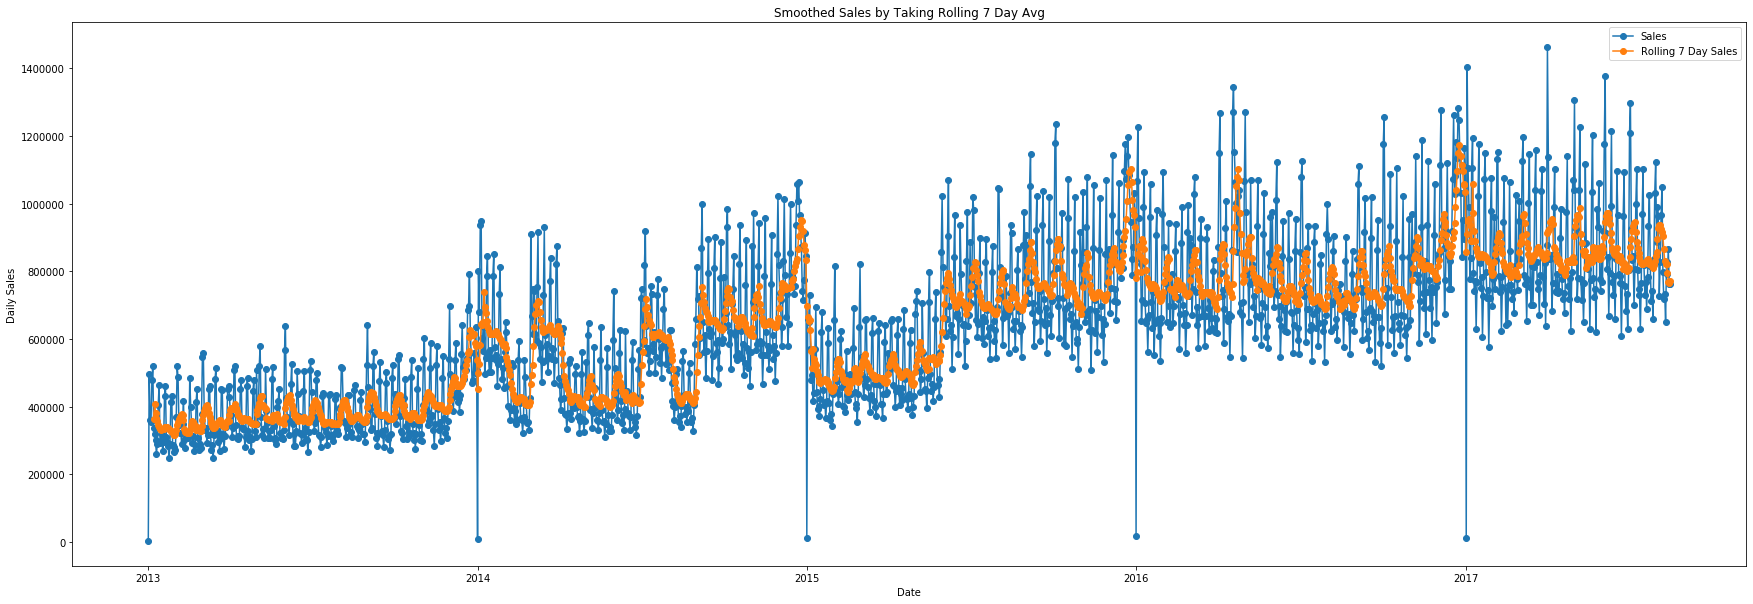

In [16]:

plt.figure(figsize=(30, 10))
plt.plot(df_daily_sales['date'] , df_daily_sales['sales'], label='Sales', marker='o') #, marker='o', color='year')
plt.plot(df_daily_sales['date'] , df_daily_sales['rolling_average_7_day'], label='Rolling 7 Day Sales', marker='o')
#sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Smoothed Sales by Taking Rolling 7 Day Avg')
plt.legend()
plt.show()

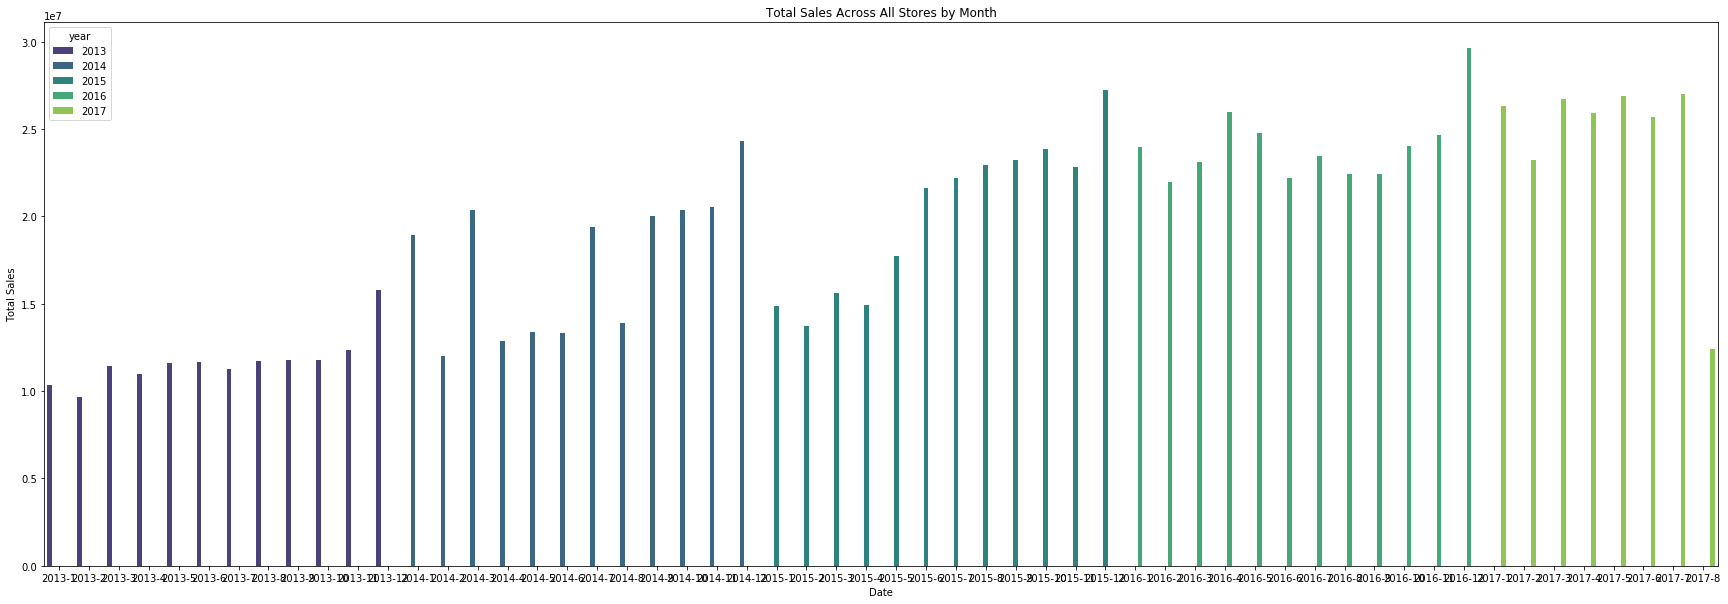

In [17]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Across All Stores by Month')
plt.show()

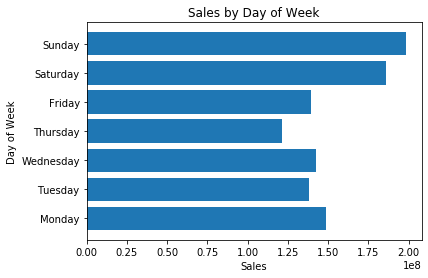

In [18]:
dow_sales = df_train.groupby('day_name')['sales'].sum().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_sales['day_name'] = pd.Categorical(dow_sales['day_name'], categories=day_order, ordered=True)
dow_sales.sort_values('day_name', inplace=True)

plt.barh(dow_sales['day_name'], dow_sales['sales'])
plt.xlabel('Sales')
plt.ylabel('Day of Week')
plt.title('Sales by Day of Week')
plt.show()

there is significant seasonality across days of the week and months in the year. Ex. Sunday and December both usually will have high sales

## check for missing values

In [19]:
### there are stores that werent open in 2013. it would be better to remove those rows

In [20]:
mindate = df_train[df_train['date']=='2013-01-01']
maxdate = df_train[df_train['date']=='2017-08-15']

print(mindate.shape[0], 'rows in the lowest date. ', maxdate.shape[0], 'rows in the max date')

1782 rows in the lowest date.  1782 rows in the max date


In [21]:
rows_per_day = df_train.groupby('date').size()
rows_per_day[rows_per_day!= 1782]

Series([], dtype: int64)

Every day has 1782 entries. That means that there are no missing values for id, store_nbr, or family. If there were no sales, the row will contain a 0 sales value

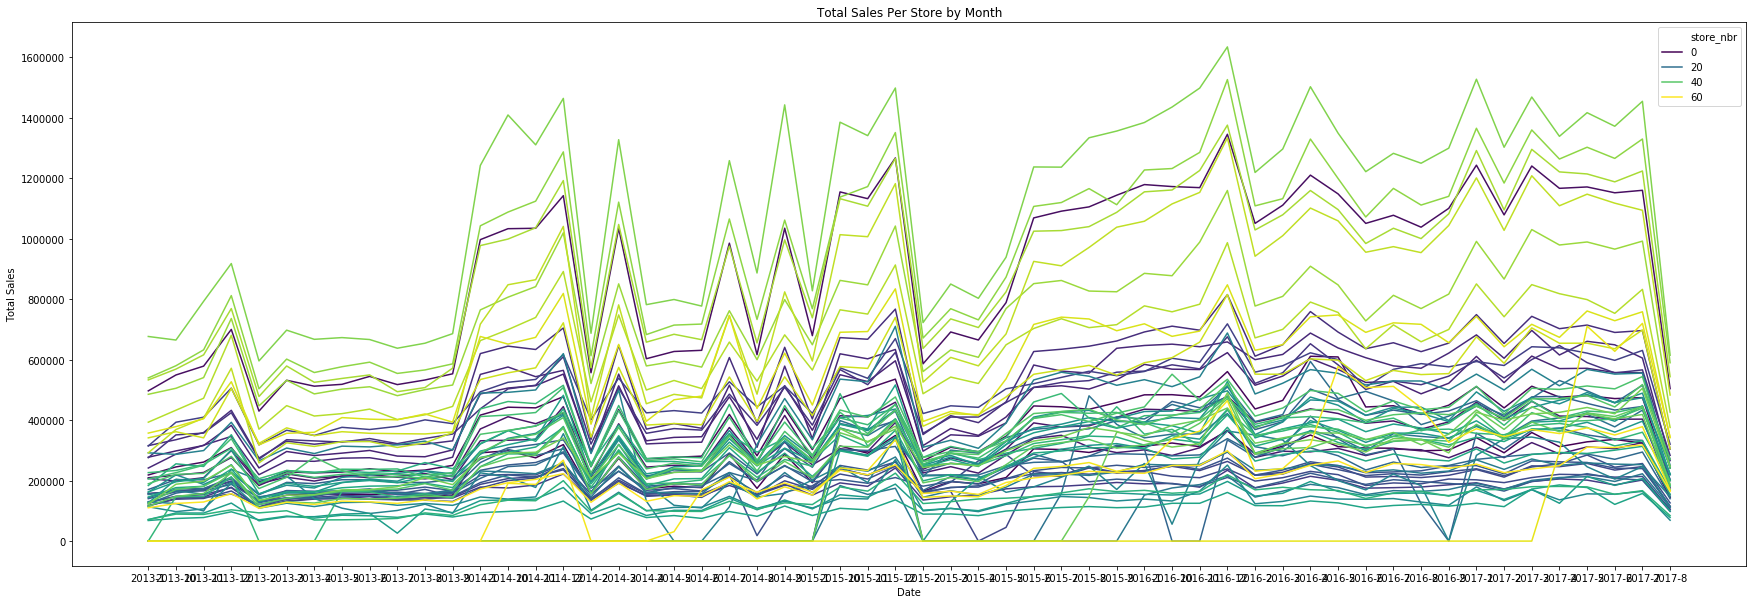

In [22]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.lineplot(x=df_monthly_sales_by_store['year'].astype(str)+'-'+df_monthly_sales_by_store['month'].astype(str), y='sales', hue='store_nbr', data=df_monthly_sales_by_store, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Per Store by Month')
plt.show()

In [23]:
#check for stores and categories with 0 sales. remove those rows. 
#certain stores wont have opened in 2013 and certain store probably dont sell certain items?? bad assumption?
df_train.head()
unique_stores = df_train['store_nbr'].drop_duplicates().sort_values()
unique_stores.count()

54

In [24]:
first_sale_date_per_store = df_train[df_train['sales'] > 0].groupby('store_nbr')['date'].min().reset_index()
first_sale_date_per_store

,store_nbr,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [25]:
df_train_min_date = pd.merge(df_train, first_sale_date_per_store, on='store_nbr')
df_train_shortened = df_train_min_date[df_train_min_date['date_x'] >= df_train_min_date['date_y']] 
df_train_shortened = df_train_shortened.drop(['date_y'], axis=1)
df_train_shortened.rename(columns={'date_x':'date'}, inplace=True)
df_train_shortened

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year
33,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,2,2,Wednesday,1,2013
34,1783,2013-01-02,1,BABY CARE,0.000,0,2,2,Wednesday,1,2013
35,1784,2013-01-02,1,BEAUTY,2.000,0,2,2,Wednesday,1,2013
36,1785,2013-01-02,1,BEVERAGES,1091.000,0,2,2,Wednesday,1,2013
37,1786,2013-01-02,1,BOOKS,0.000,0,2,2,Wednesday,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017


### Always predict 0 for items that are never sold at stores

In [26]:
never_sold = df_train_shortened.groupby(['store_nbr','family'])['sales'].sum().reset_index()
never_sold = never_sold[never_sold['sales']==0].sort_values(['store_nbr','family'])
never_sold

,store_nbr,family,sales
1,1,BABY CARE,0.0
268,9,BOOKS,0.0
301,10,BOOKS,0.0
334,11,BOOKS,0.0
367,12,BOOKS,0.0
397,13,BABY CARE,0.0
400,13,BOOKS,0.0
433,14,BOOKS,0.0
449,14,LAWN AND GARDEN,0.0
466,15,BOOKS,0.0


## merge train with oil and holidays

In [27]:
df_train_shortened['date']

33        2013-01-02
34        2013-01-02
35        2013-01-02
36        2013-01-02
37        2013-01-02
             ...    
3000883   2017-08-15
3000884   2017-08-15
3000885   2017-08-15
3000886   2017-08-15
3000887   2017-08-15
Name: date, Length: 2778831, dtype: datetime64[ns]

In [28]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays['date'] 

0     2012-03-02
1     2012-04-01
2     2012-04-12
3     2012-04-14
4     2012-04-21
         ...    
345   2017-12-22
346   2017-12-23
347   2017-12-24
348   2017-12-25
349   2017-12-26
Name: date, Length: 350, dtype: datetime64[ns]

In [29]:
dups = df_holidays.duplicated(subset='date', keep=False)
dups

0      False
1      False
2      False
3      False
4      False
       ...  
345     True
346    False
347    False
348    False
349    False
Length: 350, dtype: bool

In [30]:
unique_holidays = df_holidays.drop_duplicates(subset=['description'])
print(unique_holidays.shape[0], 'unique holidays')

103 unique holidays


In [31]:
#combine train with oil and holidays. creates dups...
df_merged = pd.merge(df_train_shortened, df_holidays, how='left', on='date')
df_merged

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year,type,locale,locale_name,description,transferred
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,2,2,Wednesday,1,2013,NaN,NaN,NaN,NaN,NaN
1,1783,2013-01-02,1,BABY CARE,0.000,0,2,2,Wednesday,1,2013,NaN,NaN,NaN,NaN,NaN
2,1784,2013-01-02,1,BEAUTY,2.000,0,2,2,Wednesday,1,2013,NaN,NaN,NaN,NaN,NaN
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,2,2,Wednesday,1,2013,NaN,NaN,NaN,NaN,NaN
4,1786,2013-01-02,1,BOOKS,0.000,0,2,2,Wednesday,1,2013,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829118,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2829119,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2829120,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2829121,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [32]:
df_train_shortened.info() #2829123 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2778831 entries, 33 to 3000887
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   day          int64         
 7   day_of_week  int64         
 8   day_name     object        
 9   month        int64         
 10  year         int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 254.4+ MB


In [33]:
print(df_train['date'].max(), df_holidays['date'].max())

2017-08-15 00:00:00 2017-12-26 00:00:00


In [34]:
df_train_shortened.head()

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,2,2,Wednesday,1,2013
34,1783,2013-01-02,1,BABY CARE,0.0,0,2,2,Wednesday,1,2013
35,1784,2013-01-02,1,BEAUTY,2.0,0,2,2,Wednesday,1,2013
36,1785,2013-01-02,1,BEVERAGES,1091.0,0,2,2,Wednesday,1,2013
37,1786,2013-01-02,1,BOOKS,0.0,0,2,2,Wednesday,1,2013


## Sales Distributions per Category

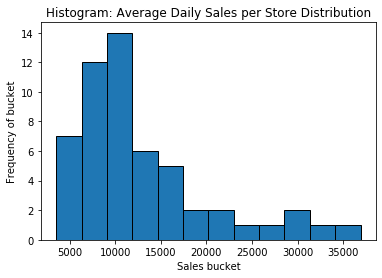

In [35]:
total_sales_per_store_daily = df_train_shortened.groupby(['store_nbr','date'])['sales'].sum().reset_index()
avg_sales_per_store = total_sales_per_store_daily.groupby(['store_nbr'])['sales'].mean().reset_index()
# Plot the bar chart
plt.hist(avg_sales_per_store['sales'], bins = 12, edgecolor = 'black')
plt.xlabel('Sales bucket')
plt.ylabel('Frequency of bucket')
plt.title('Histogram: Average Daily Sales per Store Distribution')
plt.show()



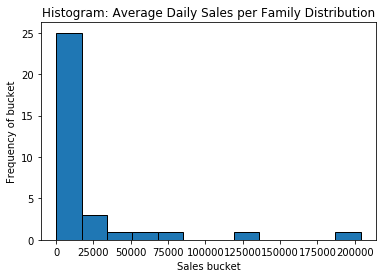

In [36]:
total_sales_per_family_daily = df_train_shortened.groupby(['family','date'])['sales'].sum().reset_index()
avg_sales_per_family = total_sales_per_family_daily.groupby(['family'])['sales'].mean().reset_index()
# Plot the bar chart
plt.hist(avg_sales_per_family['sales'], bins = 12, edgecolor = 'black')
plt.xlabel('Sales bucket')
plt.ylabel('Frequency of bucket')
plt.title('Histogram: Average Daily Sales per Family Distribution')
plt.show()


In [37]:
outlier_families = avg_sales_per_family[avg_sales_per_family['sales']>100000]
outlier_families

,family,sales
3,BEVERAGES,128832.830166
12,GROCERY I,203956.493400


the avg daily sales per store looks like a normal distribution with a right skew. <br> the avg daily sales per family chart has most families grouping on the low sales with 2 huge outliers, beverages and groceries


## Outlier analysis

## Hypothesis Testing ##

#### null hypothesis: promotions have no effect on sales <br> alternative: promotions increase sales (mean>0)

## Holidays ###

#### clean holidays data

In [38]:
# transferred  = True is a holiday that was observed on a different day
df_holidays_real = df_holidays[df_holidays['transferred']==False] 
df_holidays_real

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [39]:
unique_holis = df_holidays_real['description'].unique()

In [56]:
#sum up sales per day to analyze holidays
df_train_summed_daily = df_train_shortened.groupby('date').agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
df_train_summed_daily

,date,onpromotion,sales
0,2013-01-01,0,2511.618999
1,2013-01-02,0,496092.417944
2,2013-01-03,0,361461.231124
3,2013-01-04,0,354459.677093
4,2013-01-05,0,477350.121229
...,...,...,...
1679,2017-08-11,14179,826373.722022
1680,2017-08-12,8312,792630.535079
1681,2017-08-13,9283,865639.677471
1682,2017-08-14,8043,760922.406081


In [57]:
# joing train to holidays. will create duplicate when a there are multiple holidays falling on same date
df_holi = pd.merge(df_train_summed_daily, df_holidays_real, on='date', how='left')
df_holi


,date,onpromotion,sales,type,locale,locale_name,description,transferred
0,2013-01-01,0,2511.618999,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,0,496092.417944,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,0,361461.231124,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,0,354459.677093,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,0,477350.121229,Work Day,National,Ecuador,Recupero puente Navidad,False
...,...,...,...,...,...,...,...,...
1709,2017-08-11,14179,826373.722022,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
1710,2017-08-12,8312,792630.535079,NaN,NaN,NaN,NaN,NaN
1711,2017-08-13,9283,865639.677471,NaN,NaN,NaN,NaN,NaN
1712,2017-08-14,8043,760922.406081,NaN,NaN,NaN,NaN,NaN


In [58]:
# set boolean column for each unique holiday
for holiday in unique_holis:
    df_holi[holiday] = df_holi['description'] == holiday

In [60]:
df_holi[(df_holi['date']=='2014-06-25')]

,date,onpromotion,sales,type,locale,locale_name,description,transferred,Fundacion de Manta,Provincializacion de Cotopaxi,...,Terremoto Manabi+28,Terremoto Manabi+29,Terremoto Manabi+30,Traslado Batalla de Pichincha,Traslado Fundacion de Guayaquil,Traslado Primer Grito de Independencia,Puente Dia de Difuntos,Recupero Puente Dia de Difuntos,Traslado Primer dia del ano,Traslado Fundacion de Quito
544,2014-06-25,354,355342.398017,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False,False,False,...,False,False,False,False,False,False,False,False,False,False
545,2014-06-25,354,355342.398017,Holiday,Local,Machala,Fundacion de Machala,False,False,False,...,False,False,False,False,False,False,False,False,False,False
546,2014-06-25,354,355342.398017,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,False,False,...,False,False,False,False,False,False,False,False,False,False
547,2014-06-25,354,355342.398017,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
#find days with multiple holidays
df_holi_dup_test = df_holidays_real.groupby('date').size().reset_index(name='count')
df_holi_dup_test = df_holi_dup_test[df_holi_dup_test['count'] > 1]
df_holi_dup_test.sort_values(by='count')

,date,count
181,2015-12-22,2
274,2017-07-03,2
265,2017-04-14,2
253,2016-12-22,2
246,2016-11-12,2
231,2016-07-24,2
229,2016-07-03,2
221,2016-05-12,2
217,2016-05-08,2
216,2016-05-07,2


In [63]:
# combines duplicates rows into 1 rows where there is a true for each holiday that falls on the given date
unique_holis_list = list(unique_holis)
agg_func = {col: 'any' for col in unique_holis_list}
aggregated_df = df_holi.groupby(['date','sales','onpromotion']).agg(agg_func).reset_index()

In [167]:
aggregated_df[aggregated_df['date']=='2014-06-25']

,date,sales,onpromotion,Fundacion de Manta,Provincializacion de Cotopaxi,Fundacion de Cuenca,Cantonizacion de Libertad,Cantonizacion de Riobamba,Cantonizacion del Puyo,Cantonizacion de Guaranda,...,Terremoto Manabi+28,Terremoto Manabi+29,Terremoto Manabi+30,Traslado Batalla de Pichincha,Traslado Fundacion de Guayaquil,Traslado Primer Grito de Independencia,Puente Dia de Difuntos,Recupero Puente Dia de Difuntos,Traslado Primer dia del ano,Traslado Fundacion de Quito
539,2014-06-25,355342.398017,354,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### OLS to determine impact of each holiday across all stores

In [65]:
#testing a date that has multiple holidays
aggregated_df[aggregated_df['date']=='2014-06-25']

,date,sales,onpromotion,Fundacion de Manta,Provincializacion de Cotopaxi,Fundacion de Cuenca,Cantonizacion de Libertad,Cantonizacion de Riobamba,Cantonizacion del Puyo,Cantonizacion de Guaranda,...,Terremoto Manabi+28,Terremoto Manabi+29,Terremoto Manabi+30,Traslado Batalla de Pichincha,Traslado Fundacion de Guayaquil,Traslado Primer Grito de Independencia,Puente Dia de Difuntos,Recupero Puente Dia de Difuntos,Traslado Primer dia del ano,Traslado Fundacion de Quito
539,2014-06-25,355342.398017,354,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#aggregated_df_ols = df_holi.groupby(['date','onpromotion']).agg(agg_func).reset_index()
# cant remember if this was used...

In [91]:
# sum everything for the date, not analyzing if holidays impact store or family bc it produces too many variables for OLS
# aggregated_df_ols = aggregated_df.drop(['family','store_nbr'],axis=1)
# believe this is obsoleted

In [68]:
# seasonality has big impact on predicted sales so need to add some variables to capture 
aggregated_df_ols = aggregated_df.copy()
aggregated_df_ols['dow'] = aggregated_df_ols['date'].dt.dayofweek
aggregated_df_ols['month'] = aggregated_df_ols['date'].dt.month
aggregated_df_ols['year'] = aggregated_df_ols['date'].dt.year
aggregated_df_ols = aggregated_df_ols.drop('date',axis=1)

In [69]:
#model seasonality with dummy vars... do i need this?
aggregated_df_ols_dummies =  pd.get_dummies(aggregated_df_ols, columns=['dow','month', 'year'], drop_first=True)

In [75]:
X = aggregated_df_ols_dummies.drop('sales',axis=1)
# add constant for linear regression
X = sm.add_constant(X)
X = X.astype(int)
y=aggregated_df_ols_dummies['sales']

In [89]:
print(X.shape, 'only have 1684 rows and 126 columns which is bare minimum for OLS conditions to be met (10-20x rows for each column)')

(1684, 126) only have 1684 rows and 126 columns which is bare minimum for OLS conditions to be met (10-20x rows for each column)


In [77]:
model_OLS = sm.OLS(y,X).fit()

In [80]:
print(model_OLS.summary())
#p values less then .05 are significant

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     68.82
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:34:29   Log-Likelihood:                -21670.
No. Observations:                1684   AIC:                         4.358e+04
Df Residuals:                    1564   BIC:                         4.423e+04
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [110]:
# remove features that have p value >.10 
pvalues = model_OLS.pvalues
alpha = .10
drop_columns = pvalues[pvalues>alpha]
drop_cols = list(drop_columns.index)
# most date columns were significant except for these 3 months. still would like to keep so there arent holes in date
drop_cols.remove('month_3')
drop_cols.remove('month_6')
drop_cols.remove('month_8')
#train_data.drop(columns=drop_cols)
print(len(drop_cols), 'holidays droped out of', len(unique_holis) - 16)

72 holidays droped out of 87


In [145]:
df_holi_shortened = df_holidays_real[~df_holidays_real['description'].isin(drop_cols)]
df_holi_shortened = df_holi_shortened.drop(['type','locale','locale_name','transferred'],axis=1)
df_holi_shortened

,date,description
1,2012-04-01,Provincializacion de Cotopaxi
10,2012-07-03,Fundacion de Santo Domingo
11,2012-07-03,Cantonizacion de El Carmen
22,2012-11-03,Independencia de Cuenca
31,2012-12-21,Navidad-4
...,...,...
344,2017-12-22,Cantonizacion de Salinas
345,2017-12-22,Navidad-3
346,2017-12-23,Navidad-2
347,2017-12-24,Navidad-1


In [146]:
#338 to 108 holidays. 15 unique holidays. some holidays are outside of train and test date range
df_holi_shortened['description'].value_counts()

Carnaval                                   10
Navidad-1                                   6
Navidad                                     6
Cantonizacion de Salinas                    6
Provincializacion de Cotopaxi               6
Navidad-2                                   6
Independencia de Cuenca                     6
Navidad-3                                   6
Fundacion de Santo Domingo                  6
Cantonizacion de El Carmen                  6
Navidad-4                                   6
Dia del Trabajo                             5
Dia de la Madre                             5
Primer dia del ano-1                        5
Primer dia del ano                          4
Independencia de Guayaquil                  3
Traslado Batalla de Pichincha               2
Terremoto Manabi+16                         1
Terremoto Manabi+21                         1
Terremoto Manabi+5                          1
Terremoto Manabi+2                          1
Terremoto Manabi+14               

#### redone train set with holidays ####

In [147]:
# still have dates with multiple holidays 
# 2017-12-22 has two holidays
df_holi_shortened

,date,description
1,2012-04-01,Provincializacion de Cotopaxi
10,2012-07-03,Fundacion de Santo Domingo
11,2012-07-03,Cantonizacion de El Carmen
22,2012-11-03,Independencia de Cuenca
31,2012-12-21,Navidad-4
...,...,...
344,2017-12-22,Cantonizacion de Salinas
345,2017-12-22,Navidad-3
346,2017-12-23,Navidad-2
347,2017-12-24,Navidad-1


In [150]:
unique_holidays = df_holi_shortened['description'].unique()
len(unique_holidays)

31

In [155]:
# set boolean column for each unique holiday
df_holiday_shortened = df_holi_shortened.copy()
for holiday in unique_holidays:
    df_holiday_shortened[holiday] = df_holiday_shortened['description'] == holiday
#df_holiday_shortened = df_holiday_shortened.drop('description', axis=1)
#dont drop description yet. might be useful later if we dont wanna use extended columns


In [169]:
unique_holidays_list = list(unique_holidays)
agg_func = {col: 'any' for col in unique_holidays_list}
df_holiday_shortened = df_holiday_shortened.groupby(['date']).agg(agg_func).reset_index()
df_holiday_shortened

,date,Provincializacion de Cotopaxi,Fundacion de Santo Domingo,Cantonizacion de El Carmen,Independencia de Cuenca,Navidad-4,Cantonizacion de Salinas,Navidad-3,Navidad-2,Navidad-1,...,Terremoto Manabi+4,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+14,Terremoto Manabi+16,Terremoto Manabi+21,Traslado Batalla de Pichincha,Traslado Primer dia del ano,Traslado Fundacion de Quito
0,2012-04-01,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2012-07-03,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2012-11-03,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2012-12-21,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2012-12-22,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2017-12-21,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
92,2017-12-22,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
93,2017-12-23,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
94,2017-12-24,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [171]:
df_holiday_shortened[df_holiday_shortened['date']=='2017-12-22']

,date,Provincializacion de Cotopaxi,Fundacion de Santo Domingo,Cantonizacion de El Carmen,Independencia de Cuenca,Navidad-4,Cantonizacion de Salinas,Navidad-3,Navidad-2,Navidad-1,...,Terremoto Manabi+4,Terremoto Manabi+5,Terremoto Manabi+6,Terremoto Manabi+7,Terremoto Manabi+14,Terremoto Manabi+16,Terremoto Manabi+21,Traslado Batalla de Pichincha,Traslado Primer dia del ano,Traslado Fundacion de Quito
92,2017-12-22,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## store groupings ##

In [178]:
df_stores
#54 stores, 17 clusters

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


## final df ##

In [173]:
df_train_shortened.shape

(2778831, 11)

In [174]:
# joing train to holidays. will create duplicate when a there are multiple holidays falling on same date
df_train_hol = pd.merge(df_train_shortened, df_holiday_shortened, on='date', how='left')
df_train_hol.shape

(2778831, 42)